In [1]:
# Бинарная кросс-энтропия и сигмоида
import os
import numpy as np
import cv2
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


DROWSY_IMG_PATH = "data/Driver Drowsiness Dataset (DDD)/Drowsy/"
NON_DROWSY_IMG_PATH = "data/Driver Drowsiness Dataset (DDD)/Non Drowsy/"
img_size = (150, 150)
max_images = 1000


def read_imgs(path, max_images=None):
    image_files = [file for file in os.listdir(path) if os.path.isfile(os.path.join(path, file))]
    images = []
    if max_images:
        image_files = image_files[:max_images]
    for img_name in tqdm(image_files):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        img = img / 255.0
        if img is not None:
            images.append(img)
    return images


# Чтение изображений
drowsy_files = np.array(read_imgs(DROWSY_IMG_PATH, max_images=max_images))
non_drowsy_files = np.array(read_imgs(NON_DROWSY_IMG_PATH, max_images=max_images))

len(drowsy_files), len(non_drowsy_files)

2023-12-13 23:58:02.592681: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-13 23:58:02.592719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-13 23:58:02.593290: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-13 23:58:02.596895: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-13 23:58:03.076892: W tensorflow/compiler/tf2

(1000, 1000)

In [2]:
# Разделение изображений на обучающую, валидационную и тестовую выборки
train_drowsy, val_test_drowsy  = train_test_split(drowsy_files, test_size=0.2, random_state=42)
val_drowsy, test_drowsy = train_test_split(val_test_drowsy , test_size=0.5, random_state=42)

train_non_drowsy, val_test_non_drowsy  = train_test_split(non_drowsy_files, test_size=0.2, random_state=42)
val_non_drowsy, test_non_drowsy = train_test_split(val_test_non_drowsy , test_size=0.5, random_state=42)

del drowsy_files
del non_drowsy_files

# Архитектура модели
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Компиляция модели
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=[Accuracy()])

2023-12-13 23:59:25.568233: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-13 23:59:25.589443: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-13 23:59:25.589486: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-13 23:59:25.590891: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-13 23:59:25.590926: I external/local_xla/xla/stream_executor

In [7]:
# Гиперпараметры
batch_size = 32
epochs = 10

# Обучение модели
model.fit(np.concatenate((train_drowsy, train_non_drowsy)), 
          np.array([1] * len(train_drowsy) + [0] * len(train_non_drowsy)),
          batch_size=batch_size, epochs=epochs,
          validation_data=(np.concatenate((val_drowsy, val_non_drowsy)),
                           np.array([1] * len(val_drowsy) + [0] * len(val_non_drowsy))))

# Оценка модели на тестовых данных
test_loss, test_accuracy = model.evaluate(np.concatenate((test_drowsy, test_non_drowsy)), 
                                          np.array([1] * len(test_drowsy) + [0] * len(test_non_drowsy)))
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/10
 5/50 [==>...........................] - ETA: 0s - loss: 3.1314e-07 - accuracy: 0.9812

2023-12-14 00:15:57.411683: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 432000000 exceeds 10% of free system memory.
2023-12-14 00:15:57.598581: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 432000000 exceeds 10% of free system memory.


50/50 [==============================] - 1s 16ms/step - loss: 3.1314e-08 - accuracy: 0.9919 - val_loss: 2.6992e-20 - val_accuracy: 1.0000
Epoch 2/10
50/50 [==============================] - 1s 14ms/step - loss: 3.0148e-13 - accuracy: 0.9969 - val_loss: 2.6993e-20 - val_accuracy: 1.0000
Epoch 3/10
50/50 [==============================] - 1s 14ms/step - loss: 5.4674e-18 - accuracy: 0.9950 - val_loss: 2.6992e-20 - val_accuracy: 1.0000
Epoch 4/10
50/50 [==============================] - 1s 14ms/step - loss: 5.1503e-14 - accuracy: 0.9956 - val_loss: 2.6992e-20 - val_accuracy: 1.0000
Epoch 5/10
50/50 [==============================] - 1s 14ms/step - loss: 0.0367 - accuracy: 0.7431 - val_loss: 4.2678e-07 - val_accuracy: 0.9850
Epoch 6/10
50/50 [==============================] - 1s 14ms/step - loss: 2.2187e-06 - accuracy: 0.9550 - val_loss: 1.3814e-10 - val_accuracy: 1.0000
Epoch 7/10
50/50 [==============================] - 1s 14ms/step - loss: 1.3590e-07 - accuracy: 0.9944 - val_loss: 3.0689

In [4]:
# Получение предсказаний модели для тестовых данных
predictions = model.predict(np.concatenate((test_drowsy, test_non_drowsy)))

7/7 [==============================] - 0s 5ms/step


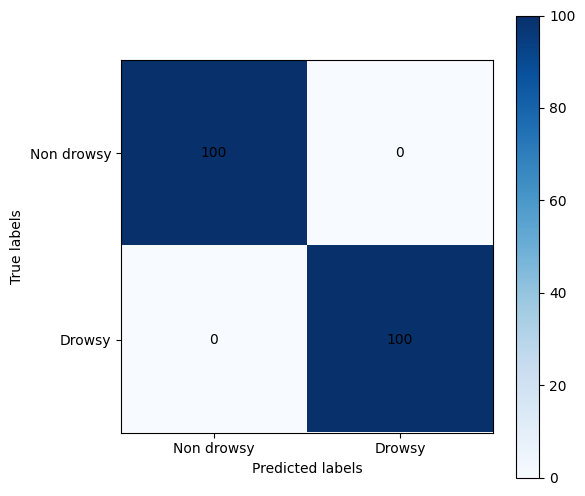

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Преобразование вероятностей в метки классов (0 или 1) с использованием порога 0.5
predicted_classes = (predictions > 0.5).astype(int)

# Создание матрицы ошибок
labels = np.array([1] * len(test_drowsy) + [0] * len(test_non_drowsy))
cm = confusion_matrix(labels, predicted_classes)

plt.figure(figsize=(6, 6))  # Установка размера графика

plt.imshow(cm, interpolation='nearest', cmap='Blues')

class_names = ["Non drowsy", "Drowsy"]

tick_marks = range(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(cm[i][j]), horizontalalignment='center', verticalalignment='center')
        
plt.colorbar()
plt.show()